[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/11-clustering/clustering.ipynb)

In [ ]:
%pip install -q pycse nbconvert
from pycse.colab import pdf

```{index} clustering, unsupervised learning
```


# Module 11: Clustering

Unsupervised learning to discover patterns in data.

## Learning Objectives

1. Understand clustering as unsupervised learning
2. Apply k-means clustering
3. Use hierarchical clustering with dendrograms
4. Apply DBSCAN for density-based clustering
5. Evaluate and compare clustering results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

## Unsupervised Learning: Finding Hidden Structure

Everything we've done so far has been **supervised learning**: we had labels (y) to train against. Clustering is different—it's **unsupervised**. We only have features (X) and want to discover natural groups.

### Why Clustering Matters in Chemical Engineering

| Application | What You're Clustering | Why |
|-------------|----------------------|-----|
| Material discovery | Material properties | Find families of similar materials |
| Process monitoring | Sensor readings | Identify operating regimes |
| Fault detection | Process variables | Distinguish normal vs abnormal states |
| Customer segmentation | Usage patterns | Group similar use cases |
| Literature mining | Document features | Find related papers |

### The Fundamental Challenge

Without labels, how do you know if clustering worked? This is the deepest question in unsupervised learning:

- **No ground truth**: You can't calculate accuracy
- **Multiple valid solutions**: Different algorithms find different structure
- **Subjective evaluation**: What counts as a "good" cluster?

### Key Insight

Clustering doesn't find "the" structure—it finds **a** structure. The algorithm's assumptions determine what it finds. Choose algorithms based on what kind of clusters you expect.

In [2]:
# Load material properties dataset
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/material_properties.csv"
df = pd.read_csv(url)

# Extract features and true labels
feature_cols = ['tensile_strength', 'elongation', 'density', 'melting_point', 'hardness']
feature_names = feature_cols  # For use in plotting
X = df[feature_cols].values
true_labels = df['true_label'].values

print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_cols}")
print(f"True cluster distribution: {dict(zip(*np.unique(true_labels, return_counts=True)))}")
df.head()

Dataset shape: (150, 5)
Features: ['tensile_strength', 'elongation', 'density', 'melting_point', 'hardness']
True cluster distribution: {np.int64(0): np.int64(50), np.int64(1): np.int64(50), np.int64(2): np.int64(50)}


,tensile_strength,elongation,density,melting_point,hardness,true_label
0,104.967142,21.620420,3.075389,153.757393,83.577874,0
1,98.617357,18.074589,3.373806,155.196723,85.607845,0
2,106.476885,16.615390,3.397186,139.799629,90.830512,0
3,115.230299,23.058381,3.259317,153.483805,90.538021,0
4,97.658466,25.154998,3.451614,154.396087,66.223306,0


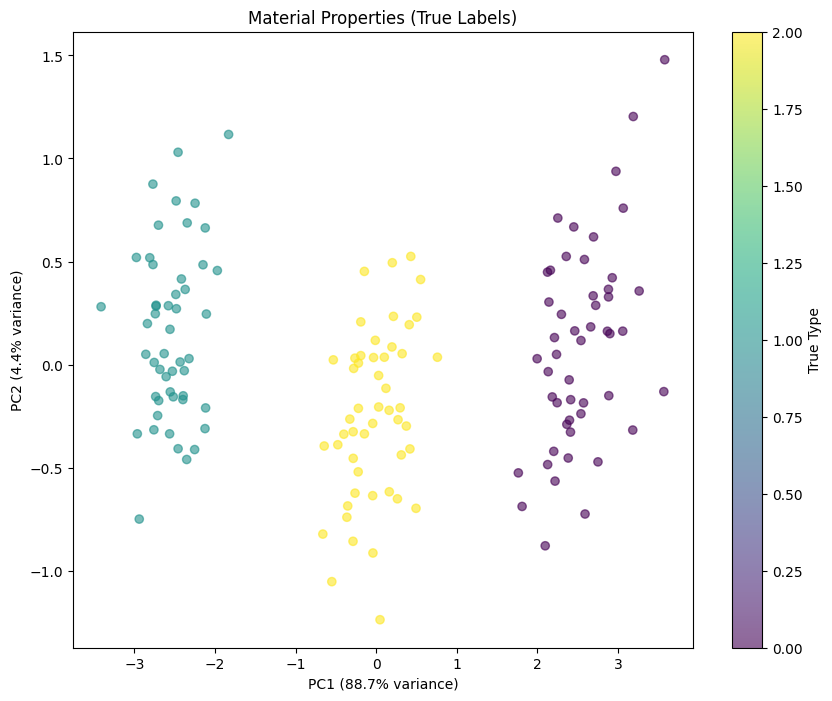

In [3]:
# Scale data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualize with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Material Properties (True Labels)')
plt.colorbar(label='True Type')
plt.show()

```{index} K-means, centroid
```


## K-Means: The Workhorse Algorithm

K-means is the most widely used clustering algorithm. It's fast, simple, and often works well.

### How It Works

1. Pick k random points as initial centroids
2. Assign each point to the nearest centroid
3. Move each centroid to the mean of its assigned points
4. Repeat until centroids stop moving

### The Key Assumption: Spherical Clusters

K-means assumes clusters are:
- **Spherical**: Similar extent in all directions
- **Similar size**: Roughly equal number of points
- **Well-separated**: Clear gaps between clusters

When these assumptions hold, k-means is excellent. When they don't, consider alternatives.

### The k Problem

You must specify k (number of clusters) in advance. This is a fundamental limitation—how do you know how many clusters exist?

Common approaches:
- **Domain knowledge**: You know there are 3 catalyst types
- **Elbow method**: Plot inertia vs k, look for diminishing returns
- **Silhouette score**: Measure cluster quality for each k

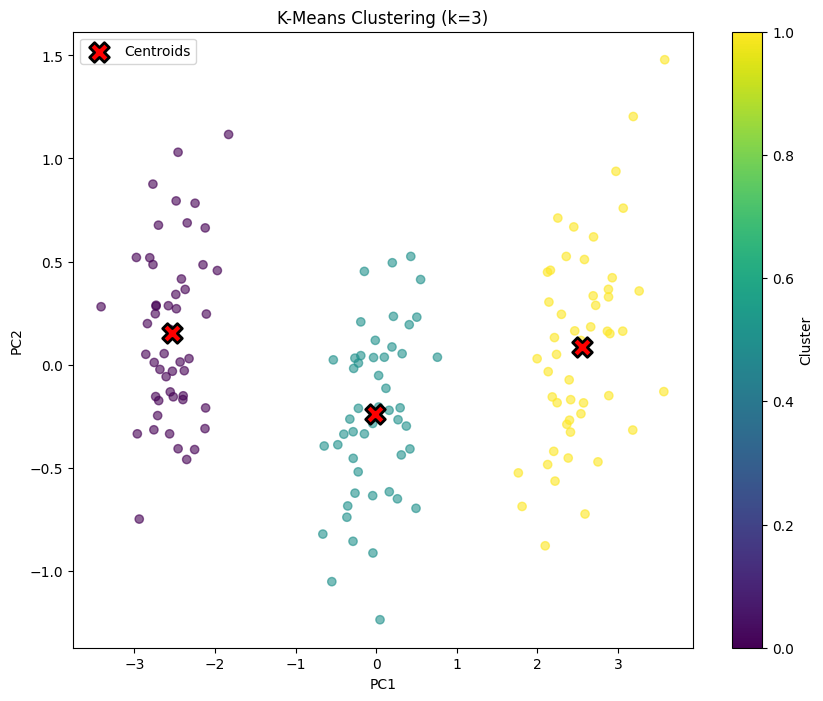

In [4]:
# K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', 
            s=200, edgecolors='black', linewidths=2, label='Centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering (k=3)')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

```{index} elbow method, silhouette score
```


## Choosing the Number of Clusters

Two common methods:
1. **Elbow method**: Plot inertia vs k, look for "elbow"
2. **Silhouette score**: Measure how well points fit their cluster

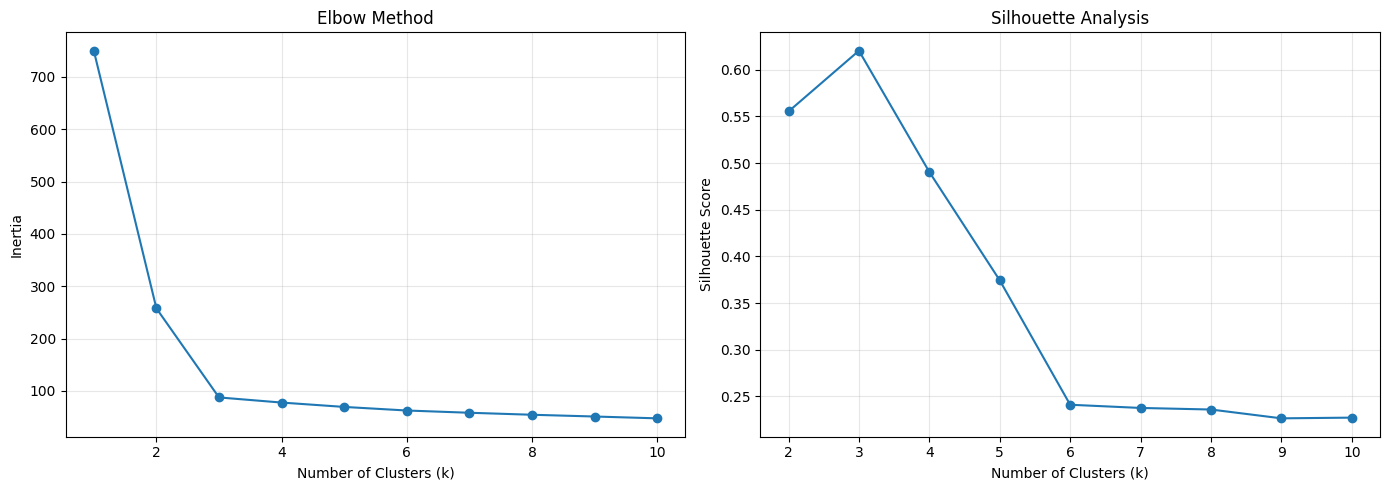

Best k by silhouette: 3


In [5]:
# Elbow method
k_range = range(1, 11)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    
    if k > 1:
        silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'o-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(range(2, 11), silhouettes, 'o-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best k by silhouette: {np.argmax(silhouettes) + 2}")

**Interpreting these plots:**

**Elbow plot (left)**: Shows inertia (within-cluster sum of squares) vs k. We're looking for an "elbow"—where adding more clusters gives diminishing returns. Here, the elbow is around k=3, after which the curve flattens. This suggests 3 clusters is a natural choice.

**Silhouette plot (right)**: Silhouette score measures how well each point fits its cluster vs neighboring clusters. Values range from -1 (wrong cluster) to +1 (perfect fit). The peak at k=3 confirms our choice.

**Why k=3?** We created data with 3 polymer types, so finding 3 clusters validates that:
1. Our synthetic data has the structure we intended
2. K-means can recover that structure
3. Both selection methods agree

In real data, you won't know the "true" k. Use these plots to guide your choice, but remember: the best k depends on your application, not just the statistics.

```{index} hierarchical clustering, dendrogram
```


## Hierarchical Clustering: See the Full Tree

Hierarchical clustering builds a tree (dendrogram) showing how clusters merge at different scales. This gives you more information than a single partition.

### Two Approaches

| Type | Process | Advantage |
|------|---------|-----------|
| **Agglomerative** | Start with n clusters, merge pairs | More common, flexible |
| **Divisive** | Start with 1 cluster, split | Less common |

### The Dendrogram: A Roadmap of Clusters

The dendrogram shows:
- **Y-axis**: Distance at which clusters merge
- **X-axis**: Individual samples (leaves)
- **Horizontal lines**: Where clusters join

Cut the dendrogram at different heights to get different numbers of clusters. A big gap suggests a natural clustering.

### When to Use Hierarchical Clustering

- Small to medium datasets (slow for large n)
- You want to see cluster structure at multiple scales
- You don't know k in advance
- You want interpretable cluster relationships

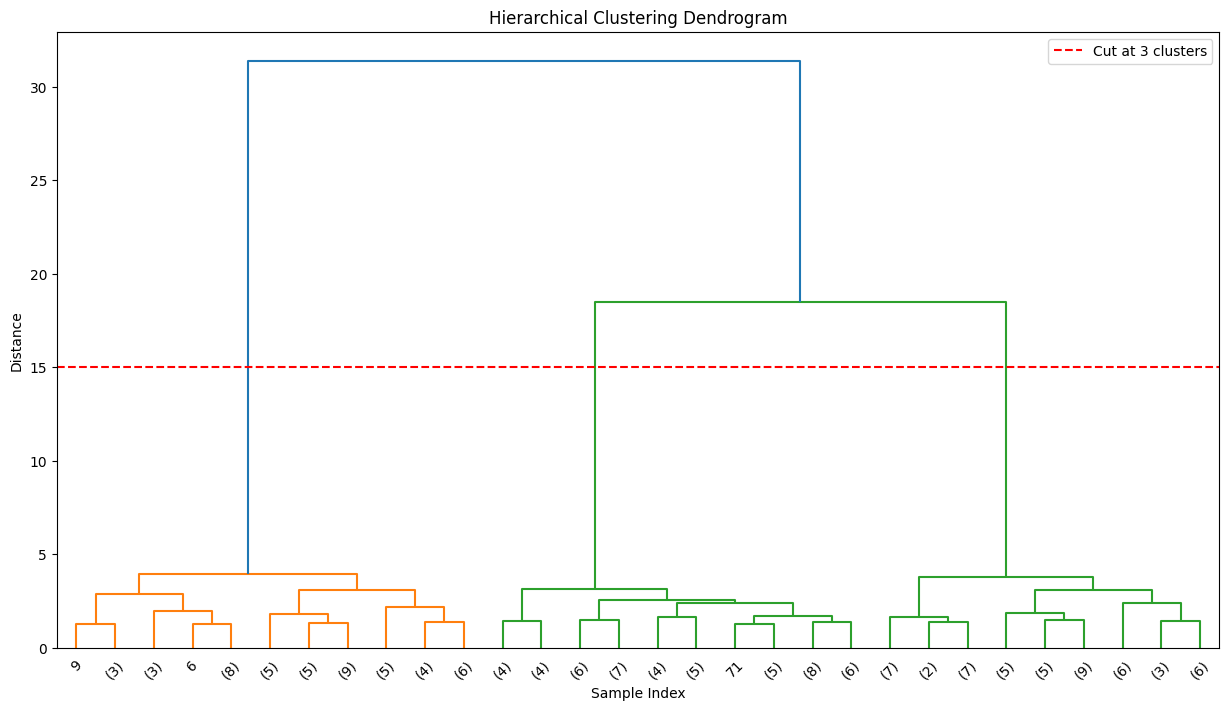

In [6]:
# Compute linkage for dendrogram
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(y=15, color='r', linestyle='--', label='Cut at 3 clusters')
plt.legend()
plt.show()

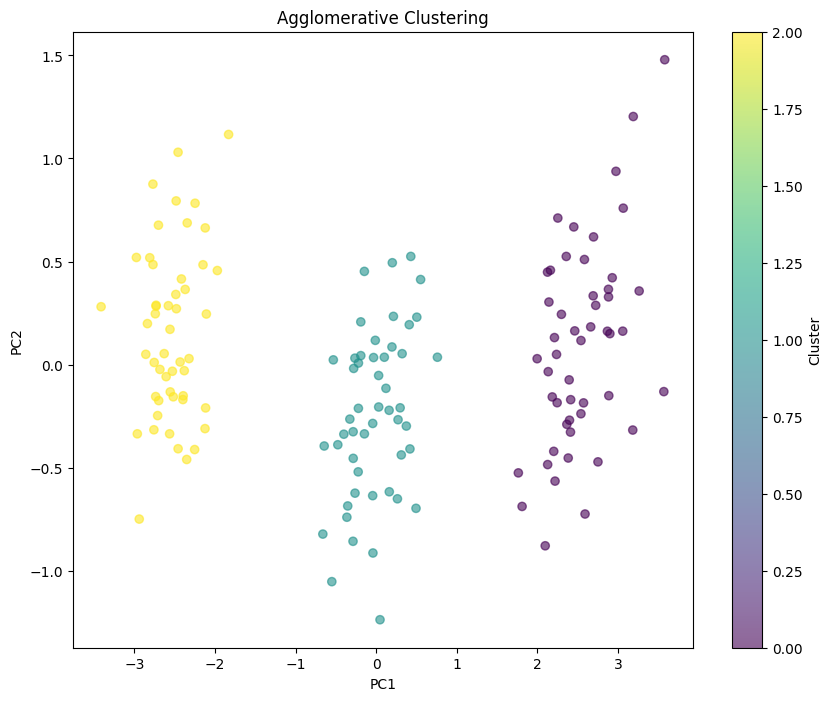

In [7]:
# Agglomerative clustering with 3 clusters
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering')
plt.colorbar(label='Cluster')
plt.show()

```{index} DBSCAN, eps, min_samples
```


## DBSCAN: Clusters of Arbitrary Shape

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) takes a completely different approach. Instead of assuming spherical clusters, it finds regions of high density.

### The Key Idea

A cluster is a dense region separated from other dense regions by sparse regions. Points in sparse regions are "noise."

### How It Works

1. A point is a **core point** if it has ≥ min_samples neighbors within radius eps
2. Points within eps of a core point belong to its cluster
3. Core points within eps of each other are in the same cluster
4. Non-core points with no nearby core points are **noise** (labeled -1)

### Strengths of DBSCAN

| K-means Limitation | DBSCAN Solution |
|--------------------|-----------------|
| Must specify k | Finds k automatically |
| Spherical clusters only | Any shape works |
| Sensitive to outliers | Identifies outliers as noise |
| All points assigned | Points can be noise |

### The Parameters

- **eps**: Maximum distance between neighbors. Too small → too many noise points. Too large → clusters merge.
- **min_samples**: Minimum points to form a core. Higher = fewer, denser clusters.

Number of clusters: 3
Number of noise points: 1


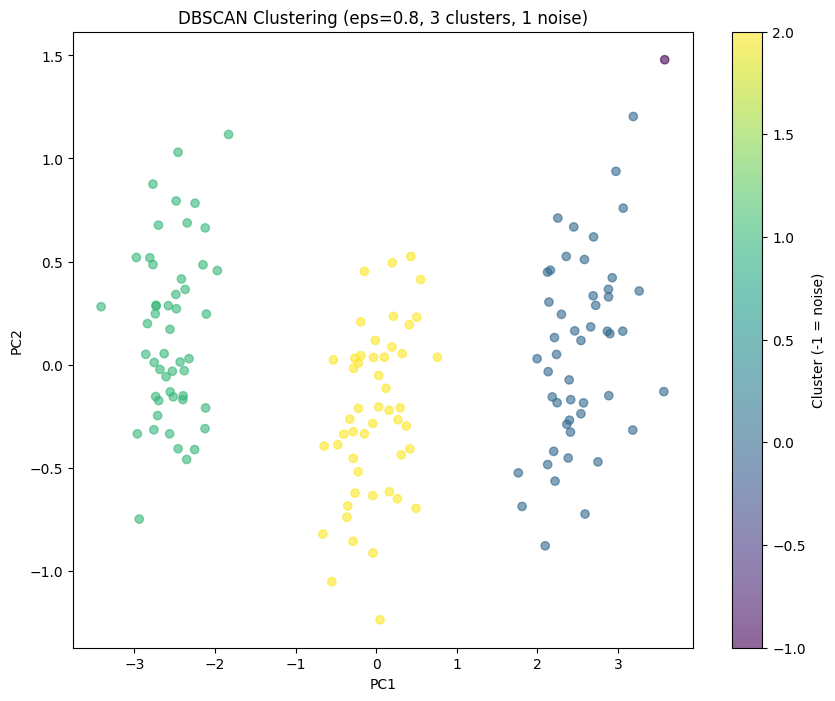

In [8]:
# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'DBSCAN Clustering (eps=0.8, {n_clusters} clusters, {n_noise} noise)')
plt.colorbar(scatter, label='Cluster (-1 = noise)')
plt.show()

**The eps parameter controls cluster granularity:**

- **eps=0.5** (too small): Many tiny clusters or noise. The algorithm sees the data as too sparse—points don't have enough nearby neighbors to form clusters.

- **eps=0.8** (about right): Recovers the 3 clusters with minimal noise. The radius is large enough to connect points within true clusters but small enough to keep clusters separate.

- **eps=1.5** (too large): Clusters start merging. Points from different true groups are now considered neighbors.

**How to choose eps in practice?**
1. Plot the k-distance graph (distance to kth nearest neighbor for each point)
2. Look for an "elbow" where distances jump
3. The elbow distance is a good starting point for eps

**The advantage over k-means**: DBSCAN found the same 3 clusters *without us specifying k=3*. It discovered the number of clusters from the data structure itself.

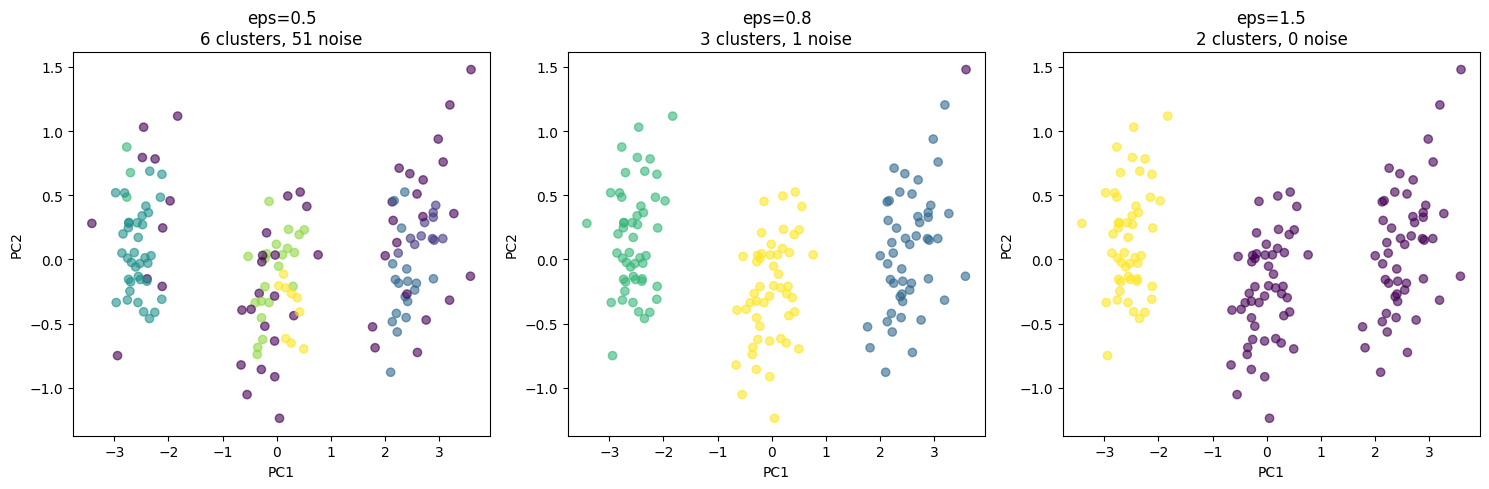

In [9]:
# Effect of eps parameter
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, eps in zip(axes, [0.5, 0.8, 1.5]):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'eps={eps}\n{n_clusters} clusters, {n_noise} noise')

plt.tight_layout()
plt.show()

## Comparing Clustering Methods

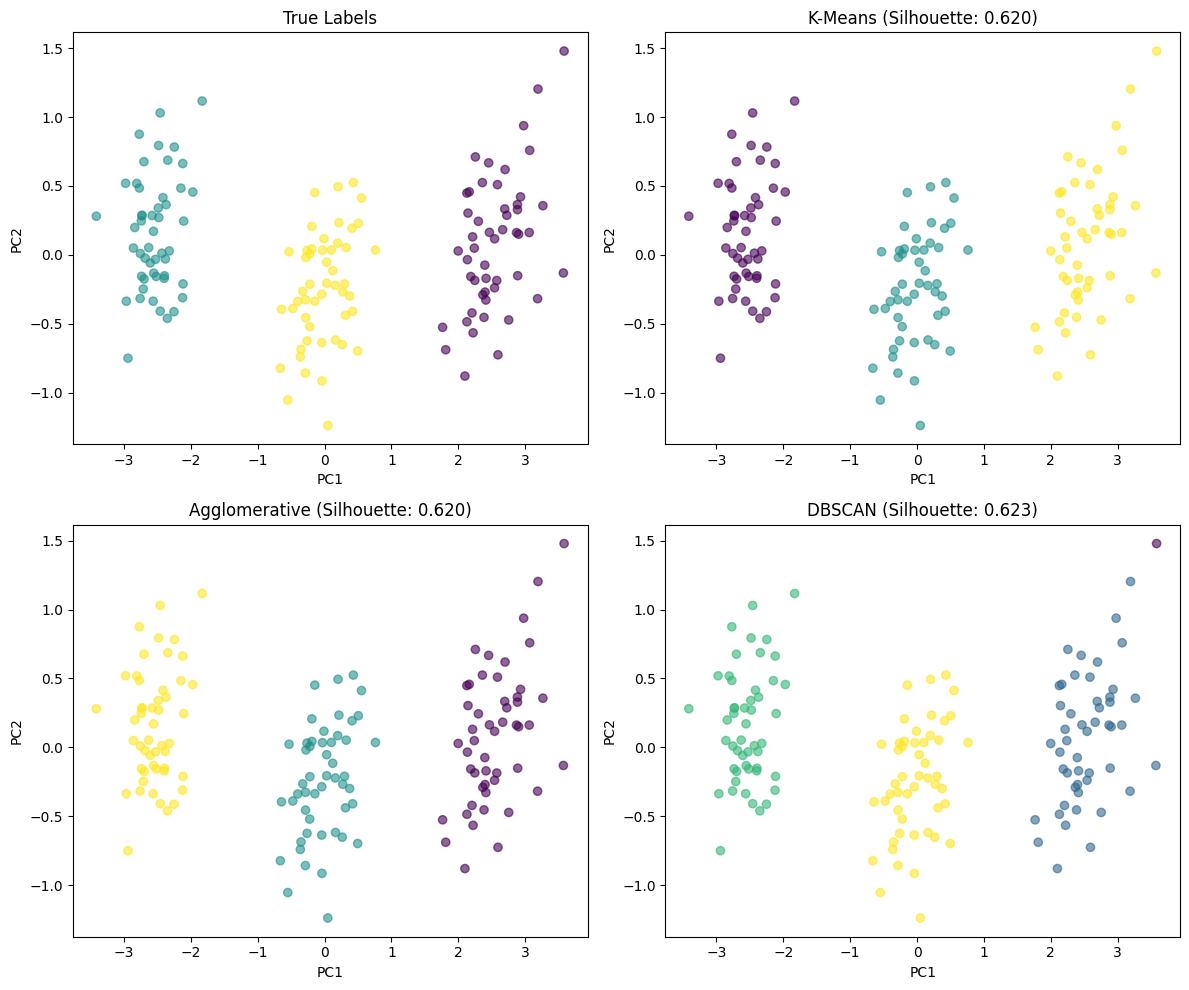

In [10]:
# Compare methods
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# True labels
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', alpha=0.6)
axes[0, 0].set_title('True Labels')

# K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0, 1].set_title(f'K-Means (Silhouette: {silhouette_score(X_scaled, kmeans_labels):.3f})')

# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', alpha=0.6)
axes[1, 0].set_title(f'Agglomerative (Silhouette: {silhouette_score(X_scaled, agg_labels):.3f})')

# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
# Calculate silhouette only for non-noise points
mask = dbscan_labels != -1
if mask.sum() > 1 and len(set(dbscan_labels[mask])) > 1:
    sil = silhouette_score(X_scaled[mask], dbscan_labels[mask])
else:
    sil = np.nan
axes[1, 1].set_title(f'DBSCAN (Silhouette: {sil:.3f})')

for ax in axes.flat:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()

In [11]:
# Compare to true labels with Adjusted Rand Index
print("Adjusted Rand Index (1.0 = perfect match):")
print(f"  K-Means: {adjusted_rand_score(true_labels, kmeans_labels):.3f}")
print(f"  Agglomerative: {adjusted_rand_score(true_labels, agg_labels):.3f}")

# For DBSCAN, only compare non-noise points
if mask.sum() > 0:
    print(f"  DBSCAN (non-noise): {adjusted_rand_score(true_labels[mask], dbscan_labels[mask]):.3f}")

Adjusted Rand Index (1.0 = perfect match):
  K-Means: 1.000
  Agglomerative: 1.000
  DBSCAN (non-noise): 1.000


## Cluster Profiling

Understanding what makes each cluster different.

In [12]:
# Add cluster labels to dataframe
df['cluster'] = kmeans_labels

# Profile each cluster
cluster_profiles = df.groupby('cluster')[feature_names].mean()
print("Cluster Profiles (Mean Values):")
print(cluster_profiles.round(2))

Cluster Profiles (Mean Values):
         tensile_strength  elongation  density  melting_point  hardness
cluster                                                                
0                   29.83      301.61     1.22          79.51     39.49
1                   56.90      100.56     2.01         120.19     58.46
2                   97.75       20.09     3.49         151.26     81.51


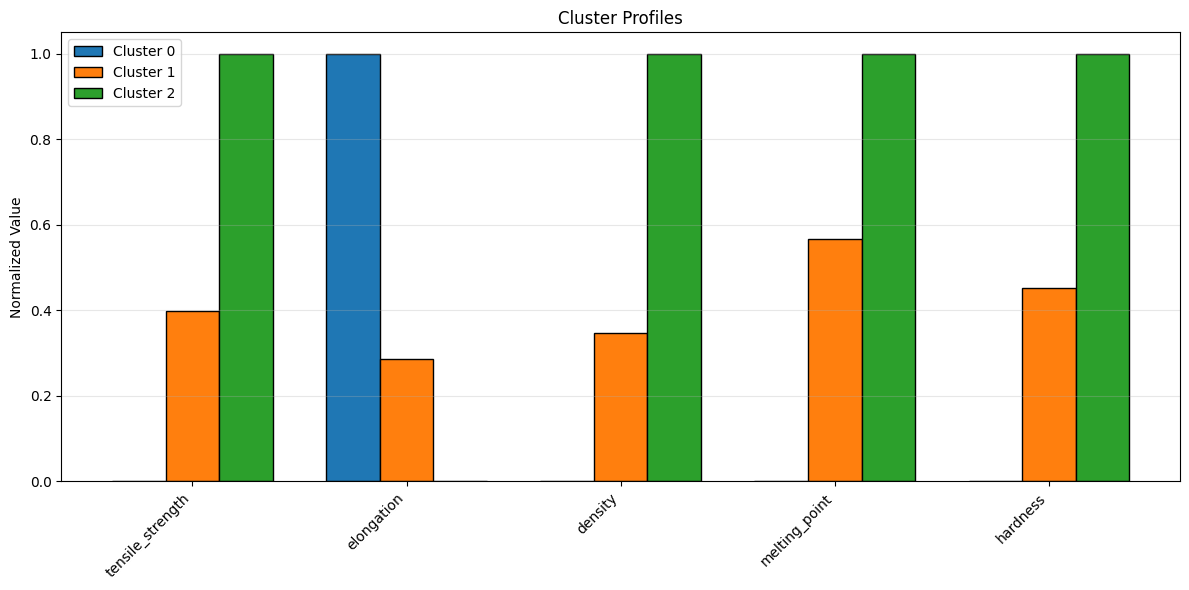

In [13]:
# Visualize cluster profiles
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize for visualization
profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

x = np.arange(len(feature_names))
width = 0.25

for i, cluster in enumerate(profiles_normalized.index):
    ax.bar(x + i*width, profiles_normalized.loc[cluster], width, 
           label=f'Cluster {cluster}', edgecolor='black')

ax.set_xticks(x + width)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_ylabel('Normalized Value')
ax.set_title('Cluster Profiles')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Self-Assessment Quiz

Test your understanding of clustering concepts.

In [14]:
%pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/11-clustering/quizzes/clustering-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources explore clustering algorithms and unsupervised learning:

1. **[Scikit-learn Clustering](https://scikit-learn.org/stable/modules/clustering.html)** - Official documentation comparing all clustering algorithms. Includes guidance on algorithm selection and the clustering comparison chart.

2. **[An Introduction to Statistical Learning, Chapter 12](https://www.statlearning.com/)** - Covers unsupervised learning including K-means, hierarchical clustering, and practical considerations for choosing the number of clusters.

3. **[DBSCAN: A Density-Based Algorithm (Ester et al., KDD 1996)](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)** - The original DBSCAN paper. Short and readable, explains the core concepts of density-based clustering.

4. **[Clustering Validation Indices (Halkidi et al., SIGMOD Record 2001)](https://dl.acm.org/doi/10.1145/568574.568575)** - Survey of methods for evaluating clustering quality without ground truth labels. Important for real-world applications.

5. **[How HDBSCAN Works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)** - Excellent visual explanation of density-based clustering. While focused on HDBSCAN, it builds intuition applicable to DBSCAN as well.

## Summary: Choosing a Clustering Algorithm

### Decision Guide

```
Do you know the number of clusters?
├── Yes, and clusters are roughly spherical
│   └── K-means (fast, reliable)
├── No, want to explore different k values
│   └── Hierarchical (see dendrogram)
└── No, expect irregular shapes or outliers
    └── DBSCAN (density-based)
```

### Algorithm Comparison

| Aspect | K-means | Hierarchical | DBSCAN |
|--------|---------|--------------|--------|
| Must specify k | Yes | No (cut dendrogram) | No (finds automatically) |
| Cluster shapes | Spherical | Depends on linkage | Any |
| Handles outliers | No | Somewhat | Yes (labels as noise) |
| Scalability | Excellent | Poor (O(n²) memory) | Good |
| Deterministic | No (random init) | Yes | Yes |

### Key Takeaways

1. **Always scale your data**: Clustering uses distances; unscaled features dominate
2. **Visualize with PCA/UMAP first**: See if cluster structure is visible
3. **Try multiple algorithms**: Different algorithms find different structure
4. **Validate clusters**: Use silhouette score, but also domain knowledge
5. **Profile your clusters**: Understand what makes each cluster distinct

### Common Pitfalls

- Forgetting to scale features
- Choosing k arbitrarily without elbow/silhouette analysis
- Using k-means for non-spherical clusters
- Expecting clustering to find "correct" groups without ground truth
- Not profiling clusters to understand what they represent

## Next Steps

In the next module, we'll learn about uncertainty quantification—understanding how confident we should be in our predictions.

---

## The Catalyst Crisis: Chapter 11 - "Patterns Without Labels"

*A story about unsupervised learning and actionable intelligence*

---

"Can you tell us which specific catalyst lots are bad?"

Frank's question was reasonable. The team had proven that catalyst was the problem. Now ChemCorp needed actionable intelligence—which lots to reject, which to accept.

The problem: they didn't have labels. No one had systematically tested catalyst quality. The only information was batch outcomes—and those depended on many factors, not just catalyst.

"We need unsupervised learning," Alex said. "Let the catalyst properties cluster naturally, then map outcomes to clusters."

She built a feature matrix for each catalyst lot: chemical composition from the certificates of analysis, physical properties from incoming QC tests. Forty dimensions of catalyst data.

K-means found three clusters. The mapping to yield was stark:

- Cluster 1: 91% good batches
- Cluster 2: 67% good batches
- Cluster 3: 23% good batches

"Three grades of catalyst," Jordan observed. "And nobody knew."

But which properties separated them? Alex dug into the cluster centers. The answer was subtle—not any single property, but a combination of trace metal ratios and surface area measurements that fell within spec individually but created problems together.

"They're all within specification," she explained to Frank. "Every lot passes incoming QC. But the *combination* of properties matters, and your specs don't capture that."

Frank leaned forward. "So what do we do?"

"You can use this clustering model to screen incoming catalyst. If a lot falls into Cluster 3, reject it or divert it to less sensitive products."

"Will the supplier cooperate?"

"They will when you show them the data." Alex pulled up the timeline. "All of Cluster 3 comes from their March-August production run. Something changed in their process during that period. With this analysis, you can have a specific conversation—not just 'your catalyst is bad,' but 'something happened in March that affected these specific properties.'"

The meeting ended with Frank promising to contact the supplier with the analysis. For the first time, he sounded almost enthusiastic.

"I've been running reactors for thirty years," he said before signing off. "Never thought I'd trust a computer to tell me about my catalyst. But this... this I can use."

After he left, Maya raised an eyebrow. "Frank's coming around."

"Data he can act on," Alex said. "That's what skeptics need. Not promises—proof."

She updated the mystery board: **Three catalyst clusters identified. Cluster 3 = bad lots, all from March-August supplier production run.**

---

*Continue to the next lecture to learn about uncertainty quantification...*